[intro and member names etc]

# Final/base HOG and SVM

Notes:     # c value and regularisation

## Setup

In [1]:
# Import required libraries

import numpy as np
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from skimage import color, io
import os
from PIL import Image
import ablation_hog
import importlib
importlib.reload(ablation_hog)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Checking it can read the data
# from subprocess import check_output
# print(check_output(["ls", "data/raw/human"]).decode("utf8"))

# Defining image dimensions for HOG
IMG_WIDTH = 64
IMG_HEIGHT = 128

RAW_HUMAN_DIR = "data/raw/human"
RAW_NONHUMAN_DIR = "data/raw/nonhuman"

PROCESSED_HUMAN_DIR = "data/processed/human"
PROCESSED_NONHUMAN_DIR = "data/processed/nonhuman"

IMAGE_EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp")

In [2]:
# For human directory
for entry in os.scandir("data/processed/human"):
    if entry.name.lower().endswith(IMAGE_EXTENSIONS):
        os.remove(entry.path)

# For nonhuman directory
for entry in os.scandir("data/processed/nonhuman"):
    if entry.name.lower().endswith(IMAGE_EXTENSIONS):
        os.remove(entry.path)

## Data processing

### Resizing and centre cropping human image examples

Starts with ~18000 images and ends with ~12000 images.

In [3]:
input_folder = RAW_HUMAN_DIR
output_folder = PROCESSED_HUMAN_DIR
os.makedirs(output_folder, exist_ok=True)

def resize_and_center_crop(img, target_width=IMG_WIDTH, target_height=IMG_HEIGHT):
    # Resize while keeping aspect ratio, but ensure the image is at least target size in both dimensions
    img_ratio = img.width / img.height
    target_ratio = target_width / target_height

    if img_ratio > target_ratio:
        # Image is wider than target — resize based on height
        new_height = target_height
        new_width = int(target_height * img_ratio)
    else:
        # Image is taller or narrower than target — resize based on width
        new_width = target_width
        new_height = int(target_width / img_ratio)

    img_resized = img.resize((new_width, new_height), Image.LANCZOS)

    # Center crop to target size
    left = (img_resized.width - target_width) // 2
    top = (img_resized.height - target_height) // 2
    right = left + target_width
    bottom = top + target_height

    return img_resized.crop((left, top, right, bottom))

for filename in os.listdir(input_folder):
    if filename.lower().endswith((IMAGE_EXTENSIONS)):
        path = os.path.join(input_folder, filename)
        img = Image.open(path)
        # img = Image.open(path).convert("RGB")
        cropped = resize_and_center_crop(img)
        cropped.save(os.path.join(output_folder, filename))

### Downscaling and obtaining non-overlapping crops of nonhuman images

Starts with 1218 nonhuman images and ends with ~13000 unique nonhuman images.

In [4]:
input_folder = RAW_NONHUMAN_DIR
output_folder = PROCESSED_NONHUMAN_DIR
os.makedirs(output_folder, exist_ok=True)

crop_id = 0  # Unique filename ID
scale_factor = 4 / 5  # Downsize images before cropping

for fname in os.listdir(input_folder):
    if fname.lower().endswith((IMAGE_EXTENSIONS)):
        path = os.path.join(input_folder, fname)
        img = Image.open(path)
        # img = Image.open(path).convert("RGB")
        # width, height = img.size

        # Resize image to */* of original size
        new_width = int(img.width * scale_factor)
        new_height = int(img.height * scale_factor)
        img_resized = img.resize((new_width, new_height), Image.LANCZOS)

        # Calculate number of non-overlapping crops that fit
        num_x = new_width // IMG_WIDTH
        num_y = new_height // IMG_HEIGHT

        for y in range(num_y):
            for x in range(num_x):
                left = x * IMG_WIDTH
                top = y * IMG_HEIGHT
                right = left + IMG_WIDTH
                bottom = top + IMG_HEIGHT

                crop = img.crop((left, top, right, bottom))
                out_path = os.path.join(output_folder, f"nonhuman_{crop_id}.jpg")
                crop.save(out_path)
                crop_id += 1

print(f"Saved {crop_id} non-overlapping 64x128 crops to {output_folder}")

Saved 13717 non-overlapping 64x128 crops to data/processed/nonhuman


## HOG and SVM training and evaluation

In [28]:
from ablation_hog import custom_hog

# Best parameters for HOG
ORIENTATIONS = 18
PIXELS_PER_CELL = (16, 16)
CELLS_PER_BLOCK = (2, 2)
BLOCK_NORM = 'L1'
FEATURE_VECTOR = True
# GRADIENT = 'scharr'
# GAMMA=1.0
# GAUSSIAN_SIGMA=0.0

In [6]:
image_size = (IMG_WIDTH, IMG_HEIGHT)

# def extract_hog_features(img_path, orientations, pixels_per_cell, block_norm, feature_vector,
#                         gradient, gamma, gaussian_sigma):
#     img = Image.open(img_path).convert("L").resize(image_size)
#     img_np = np.array(img)
    
#     hog_features = custom_hog(img_np, orientations=orientations, pixels_per_cell=pixels_per_cell,
#                             block_norm=block_norm, transform_sqrt=True,
#                             feature_vector=feature_vector, unsigned=True, gradient=gradient,
#                             gamma=gamma, gaussian_sigma=gaussian_sigma)

#     return hog_features

def extract_hog(human_dir, nonhuman_dir, orientations, pixels_per_cell, cells_per_block, block_norm, feature_vector):
    features = []
    labels = []
    
    # Process human images (label = 1)
    for fname in os.listdir(human_dir):
        path = os.path.join(human_dir, fname)
        img = Image.open(path).convert("L").resize(image_size)
        img_np = np.array(img)
        hog_feature = hog(img_np,
                            orientations=orientations,
                            pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block,
                            block_norm=block_norm,
                            feature_vector=feature_vector)
        features.append(hog_feature)
        labels.append(1)

    # Process nonhuman images (label = 0)
    for fname in os.listdir(nonhuman_dir):
        path = os.path.join(nonhuman_dir, fname)
        img = Image.open(path).convert("L").resize(image_size)
        img_np = np.array(img)
        hog_feature = hog(img_np,
                            orientations=orientations,
                            pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block,
                            block_norm=block_norm,
                            feature_vector=feature_vector)
        features.append(hog_feature)
        labels.append(0)
    
    return features, labels

def split_data(features, labels):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42
    )
    return X_train, X_test, y_train, y_test

In [20]:
def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    miss_rate = 1 - recall
    fppw = fp / len(y_true)  # False positives per window

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Miss Rate": miss_rate,
        "FPPW": fppw
    }

def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    # Fit the model
    clf = LinearSVC(random_state=42)
    clf.fit(X_train, y_train)

    # Predict on train set
    y_train_pred = clf.predict(X_train)

    # Predict on test set
    y_test_pred = clf.predict(X_test)

    # Compute metrics
    train_metrics = compute_metrics(y_train, y_train_pred)
    test_metrics = compute_metrics(y_test, y_test_pred)

    return train_metrics, test_metrics

In [29]:
def full_pipeline(human_dir, nonhuman_dir, orientations, pixels_per_cell, cells_per_block, block_norm, feature_vector):
    features, labels = extract_hog(human_dir, nonhuman_dir, orientations, pixels_per_cell, cells_per_block, block_norm, feature_vector)
    X_train, X_test, y_train, y_test = split_data(features, labels)
    train_metrics, test_metrics = train_and_evaluate_model(X_train, y_train, X_test, y_test)
    return train_metrics, test_metrics

# Run the full pipeline on the best parameters
train_metrics, test_metrics = full_pipeline(
    human_dir=PROCESSED_HUMAN_DIR,
    nonhuman_dir=PROCESSED_NONHUMAN_DIR,
    orientations=ORIENTATIONS,
    pixels_per_cell=PIXELS_PER_CELL,
    cells_per_block=CELLS_PER_BLOCK,
    block_norm=BLOCK_NORM,
    feature_vector=FEATURE_VECTOR,
)

# Combine into a DataFrame
df = pd.DataFrame([train_metrics, test_metrics], index=["Train Set", "Test Set"])

# Display nicely
print("Evaluation Metrics:")
display(df.round(4))

Evaluation Metrics:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,FPPW
Train Set,0.9471,0.9543,0.9540,0.9541,0.0460,0.0264
Test Set,0.9344,0.9451,0.9408,0.9430,0.0592,0.0315


In [9]:
# TODO: Optimise SVM parameters for further performance improvement
RUN_GRIDSEARCH = False
BEST_C = 10

# if RUN_GRIDSEARCH:
#         print("Running GridSearchCV to find best C...")
#         param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
#         svc = SVC(kernel='linear')
#         grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
#         grid_search.fit(X_train, y_train)
#         C = grid_search.best_params_['C']
#         print(f"Best parameters found: {grid_search.best_params_}")
#         print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

#     print(f"\nTraining final model with C={C}...")
#     clf = SVC(C=C, kernel='linear')
#     clf.fit(X_train, y_train)

# Ablation studies

## Study 1: Effect of number of orientation bins on miss rate and FPPW

In [22]:
orientations = [6, 8, 9, 12, 18]
orientation_metrics = []

for orientation in orientations:
    train_metrics, test_metrics = full_pipeline(
        human_dir=PROCESSED_HUMAN_DIR,
        nonhuman_dir=PROCESSED_NONHUMAN_DIR,
        orientations=orientation,
        pixels_per_cell=PIXELS_PER_CELL,
        cells_per_block=CELLS_PER_BLOCK,
        block_norm=BLOCK_NORM,
        feature_vector=FEATURE_VECTOR,
    )

    # Combine into a DataFrame
    df = pd.DataFrame([train_metrics, test_metrics], index=["Train Set", "Test Set"])

    # Display nicely
    print(f"Evaluation Metrics for orientation {orientation}:")
    display(df.round(4))

    orientation_metrics.append((train_metrics, test_metrics))

Evaluation Metrics for orientation 6:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,FPPW
Train Set,0.9554,0.9614,0.9613,0.9613,0.0387,0.0222
Test Set,0.9103,0.9253,0.9186,0.9220,0.0814,0.0427


Evaluation Metrics for orientation 8:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,FPPW
Train Set,0.9708,0.9746,0.9748,0.9747,0.0252,0.0147
Test Set,0.9145,0.9300,0.9210,0.9255,0.0790,0.0400


Evaluation Metrics for orientation 9:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,FPPW
Train Set,0.9767,0.9790,0.9806,0.9798,0.0194,0.0121
Test Set,0.9099,0.9287,0.9138,0.9212,0.0862,0.0404


Evaluation Metrics for orientation 12:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,FPPW
Train Set,0.9907,0.9911,0.9928,0.992,0.0072,0.0051
Test Set,0.9174,0.9336,0.9224,0.928,0.0776,0.0378


Evaluation Metrics for orientation 18:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,FPPW
Train Set,0.9986,0.9981,0.9995,0.9988,0.0005,0.0011
Test Set,0.9174,0.9334,0.9226,0.9280,0.0774,0.0380


[({'Accuracy': 0.9554329371816639, 'Precision': 0.9614457831325302, 'Recall': 0.9612527604898615, 'F1 Score': 0.9613492621222769, 'Miss Rate': 0.038747239510138476, 'FPPW': np.float64(0.022225652106806607)}, {'Accuracy': 0.9103395061728395, 'Precision': 0.9253167969803181, 'Recall': 0.9186295503211992, 'F1 Score': 0.9219610476830087, 'Miss Rate': 0.0813704496788008, 'FPPW': np.float64(0.04274691358024691)}), ({'Accuracy': 0.9708288316098164, 'Precision': 0.974576838161504, 'Recall': 0.9748377166566286, 'F1 Score': 0.9747072599531615, 'Miss Rate': 0.02516228334337145, 'FPPW': np.float64(0.01466275659824047)}, {'Accuracy': 0.9145061728395062, 'Precision': 0.93, 'Recall': 0.9210385438972163, 'F1 Score': 0.9254975793437332, 'Miss Rate': 0.07896145610278371, 'FPPW': np.float64(0.039969135802469136)}), ({'Accuracy': 0.9766939342491125, 'Precision': 0.9790205117926104, 'Recall': 0.9805929197617613, 'F1 Score': 0.979806084921431, 'Miss Rate': 0.019407080238238672, 'FPPW': np.float64(0.01211606

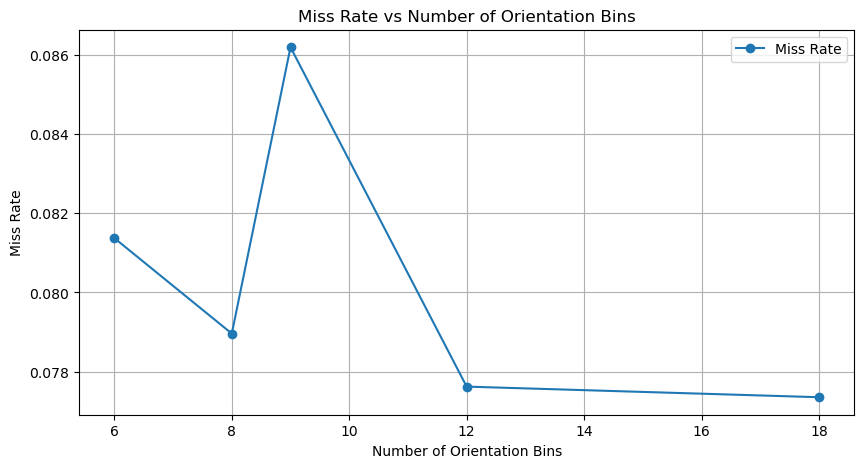

In [23]:
orientation_test_miss_rates = [test["Miss Rate"] for _, test in orientation_metrics]

# Plot Miss Rate vs Orientation Bins
plt.figure(figsize=(10, 5))
plt.plot(orientations, orientation_test_miss_rates, marker='o', label='Miss Rate')
plt.title('Miss Rate vs Number of Orientation Bins')
plt.xlabel('Number of Orientation Bins')
plt.ylabel('Miss Rate')
plt.grid(True)
plt.legend()
plt.show()

## Study 2: Effect of block size on ...

In [24]:
block_sizes = [(8, 8), (16, 16), (24, 24), (32, 32)]
block_size_metrics = []

for block_size in block_sizes:
    train_metrics, test_metrics = full_pipeline(
        human_dir=PROCESSED_HUMAN_DIR,
        nonhuman_dir=PROCESSED_NONHUMAN_DIR,
        orientations=ORIENTATIONS,
        pixels_per_cell=block_size,
        cells_per_block=CELLS_PER_BLOCK,
        block_norm=BLOCK_NORM,
        feature_vector=FEATURE_VECTOR,
    )

    # Combine into a DataFrame
    df = pd.DataFrame([train_metrics, test_metrics], index=["Train Set", "Test Set"])

    # Display nicely
    print(f"Evaluation Metrics for block size {block_size}:")
    display(df.round(4))

    block_size_metrics.append((train_metrics, test_metrics))

Evaluation Metrics for block size (8, 8):


,Accuracy,Precision,Recall,F1 Score,Miss Rate,FPPW
Train Set,0.9767,0.9790,0.9806,0.9798,0.0194,0.0121
Test Set,0.9099,0.9287,0.9138,0.9212,0.0862,0.0404


Evaluation Metrics for block size (16, 16):


,Accuracy,Precision,Recall,F1 Score,Miss Rate,FPPW
Train Set,0.9408,0.9477,0.9498,0.9488,0.0502,0.0302
Test Set,0.9242,0.9339,0.9347,0.9343,0.0653,0.0381


Evaluation Metrics for block size (24, 24):


,Accuracy,Precision,Recall,F1 Score,Miss Rate,FPPW
Train Set,0.9014,0.9091,0.9211,0.915,0.0789,0.0531
Test Set,0.8935,0.9048,0.9111,0.908,0.0889,0.0552


Evaluation Metrics for block size (32, 32):


,Accuracy,Precision,Recall,F1 Score,Miss Rate,FPPW
Train Set,0.8913,0.8922,0.9230,0.9073,0.0770,0.0643
Test Set,0.8844,0.8942,0.9069,0.9005,0.0931,0.0619


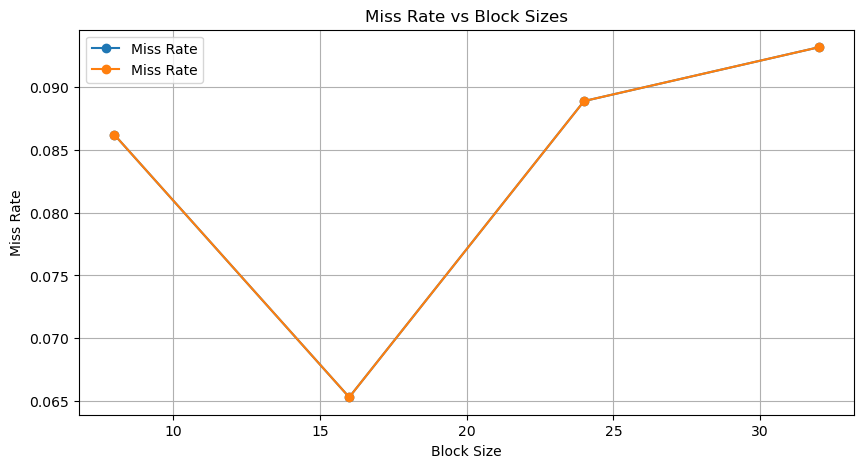

In [26]:
block_size_test_miss_rates = [test["Miss Rate"] for _, test in block_size_metrics]

# Plot Miss Rate vs Block Sizes
plt.figure(figsize=(10, 5))
plt.plot(block_sizes, block_size_test_miss_rates, marker='o', label='Miss Rate')
plt.title('Miss Rate vs Block Sizes')
plt.xlabel('Block Size')
plt.ylabel('Miss Rate')
plt.grid(True)
plt.legend()
plt.show()

## Study 3: Effect of normalisation technique on ...

In [25]:
norm_techniques = ['L1', 'L1-sqrt', 'L2', 'L2-Hys']
norm_technique_metrics = []

for norm_technique in norm_techniques:
    train_metrics, test_metrics = full_pipeline(
        human_dir=PROCESSED_HUMAN_DIR,
        nonhuman_dir=PROCESSED_NONHUMAN_DIR,
        orientations=ORIENTATIONS,
        pixels_per_cell=PIXELS_PER_CELL,
        cells_per_block=CELLS_PER_BLOCK,
        block_norm=norm_technique,
        feature_vector=FEATURE_VECTOR,
    )

    # Combine into a DataFrame
    df = pd.DataFrame([train_metrics, test_metrics], index=["Train Set", "Test Set"])

    # Display nicely
    print(f"Evaluation Metrics for normalisation technique {norm_technique}:")
    display(df.round(4))

    norm_technique_metrics.append((train_metrics, test_metrics))

Evaluation Metrics for normalisation technique L1:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,FPPW
Train Set,0.9707,0.9765,0.9726,0.9745,0.0274,0.0135
Test Set,0.9275,0.9373,0.9368,0.9371,0.0632,0.0361


Evaluation Metrics for normalisation technique L1-sqrt:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,FPPW
Train Set,0.9751,0.9795,0.9772,0.9784,0.0228,0.0118
Test Set,0.9247,0.9352,0.9342,0.9347,0.0658,0.0373


Evaluation Metrics for normalisation technique L2:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,FPPW
Train Set,0.9872,0.9886,0.9892,0.9889,0.0108,0.0066
Test Set,0.9159,0.9286,0.9253,0.9269,0.0747,0.0410


Evaluation Metrics for normalisation technique L2-Hys:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,FPPW
Train Set,0.9767,0.9790,0.9806,0.9798,0.0194,0.0121
Test Set,0.9099,0.9287,0.9138,0.9212,0.0862,0.0404


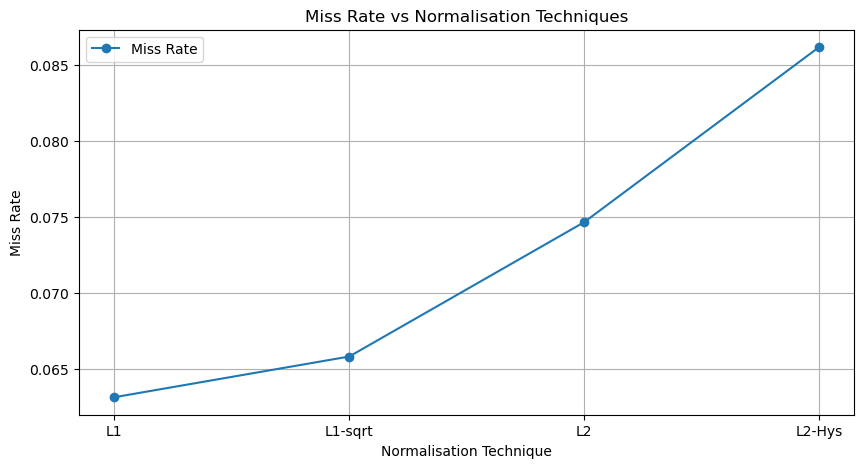

In [27]:
norm_technique_test_miss_rates = [test["Miss Rate"] for _, test in norm_technique_metrics]

# Plot Miss Rate vs Normalisation Techniques
plt.figure(figsize=(10, 5))
plt.plot(norm_techniques, norm_technique_test_miss_rates, marker='o', label='Miss Rate')
plt.title('Miss Rate vs Normalisation Techniques')
plt.xlabel('Normalisation Technique')
plt.ylabel('Miss Rate')
plt.grid(True)
plt.legend()
plt.show()

### Visualisation of HOG and other debugging (might be useful later)

0
[0.24485584 0.03250129 0.05814783 ... 0.03887927 0.01072847 0.02250082]


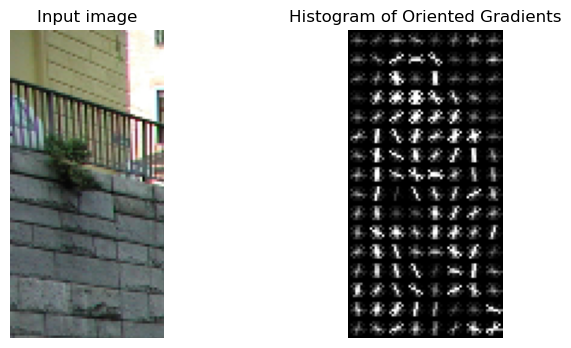

In [ ]:
from skimage import data, exposure

# img = Image.open(img_path).convert("L").resize(image_size)


def extract_hog_features(img_path):
    img = Image.open(img_path).convert("L").resize(image_size)
    img_np = np.array(img)
    hog_features, hog_image = hog(
        img_np,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        feature_vector=True,
        visualize=True,
        # channel_axis=-1,
    )
    return hog_features, hog_image

print(labels[-1])
hog_features, hog_image = extract_hog_features('data/processed/human/0_8.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

print(hog_features)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

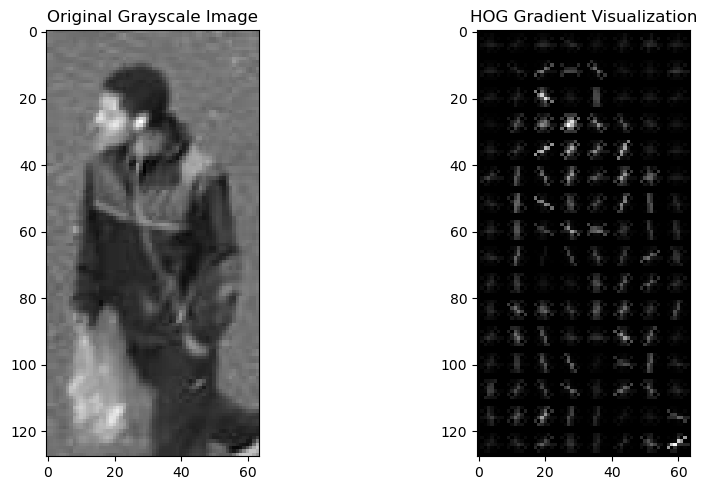

In [ ]:
# Load and convert image to grayscale
image = io.imread("data/processed/human/0_8.jpg")  # replace with your path
gray_image = color.rgb2gray(image)

# Compute HOG features and visualization
features, hog_image = hog(
    gray_image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    block_norm='L2-Hys'
)

# Plot original and HOG gradient image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap="gray")
plt.title("Original Grayscale Image")

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap="gray")
plt.title("HOG Gradient Visualization")

plt.tight_layout()
plt.show()